In [2]:
import glob
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
import faiss
from utils import *
import pickle


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pathlib
from skimage.io import imread
from skimage.transform import resize
import PIL
import pickle
from sklearn.neighbors import NearestNeighbors
import matplotlib.image as mpimg
import tensorflow as tf
print(tf.__version__)
# from style_stack import StyleStack
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image


2.17.0


## Loading Model

In [3]:
data_dir = pathlib.Path('./images')

IMG_SIZE = (224, 224)
batch_size = 50

preprocess_input = tf.keras.applications.vgg16.preprocess_input

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset='training',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    subset='validation',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1514 images belonging to 4 classes.
Found 376 images belonging to 4 classes.


In [4]:
weights_file = 'vgg16_furniture_classifier_1129.keras'

base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [5]:
x = base_model.output
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='fc1')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='fc2')(x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(1024, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.2*0.5)(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.load_weights(weights_file)
model.summary()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        16,38

 Total params: 134,276,932 (512.23 MB)

 Trainable params: 134,276,932 (512.23 MB)

 Non-trainable params: 0 (0.00 B)

## Preparing images path

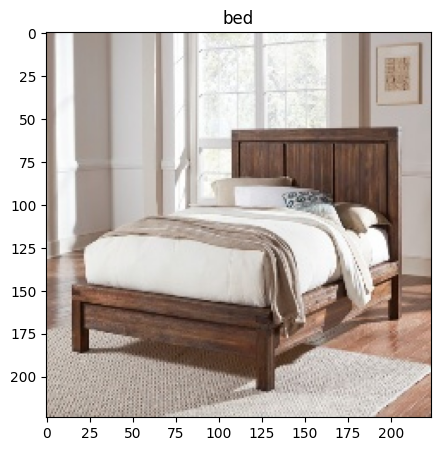

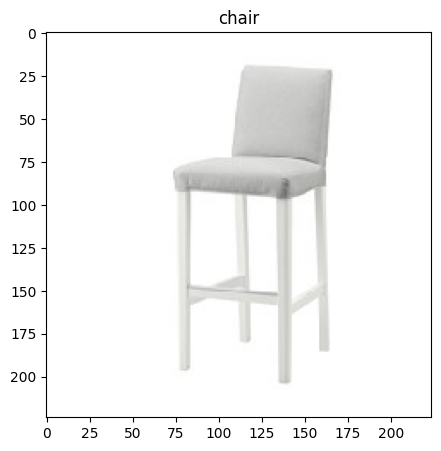

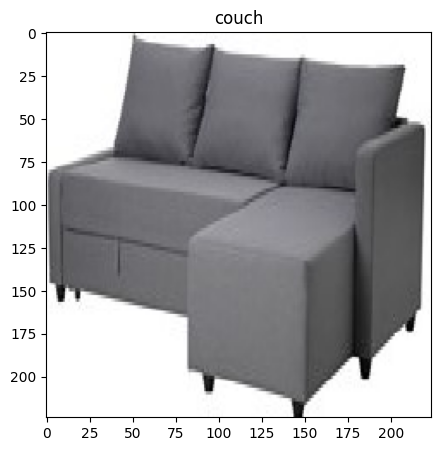

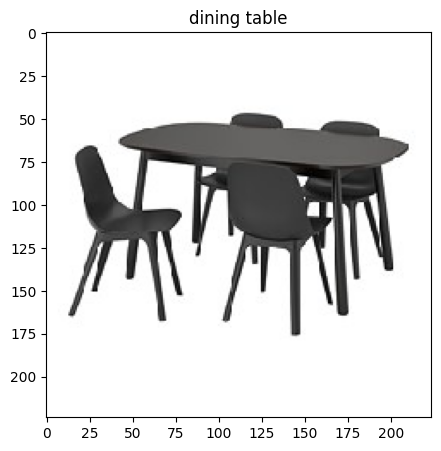

In [6]:
import os
data_dir = pathlib.Path('./images')

def get_img_by_class(dir_, class_list):
    img_by_class = {}
    for class_ in class_list:
        paths = glob.glob(os.path.join(dir_, f'{class_}/*'))
        img_by_class[class_] = paths
    return img_by_class


def preview_img_by_class(img_by_class):
    for class_, paths in img_by_class.items():
        img, _ = load_image(paths[0], (224, 224))
        plt.figure(figsize = (5, 5))
        plt.imshow(img)
        plt.title(class_)

dir_ = './images'

styles = [
    'bed',
    'chair',
    'couch',
    'dining table'
]
                          
art_by_style = get_img_by_class(dir_, styles)
preview_img_by_class(art_by_style)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
predicted objects and probabilities
bed 0.0
chair 0.0
couch 1.0
dining table 0.0


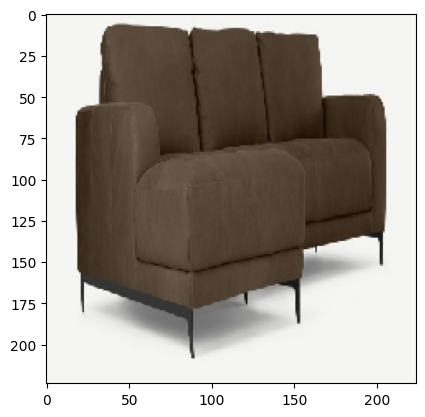

In [7]:
classes = styles = [
    'bed',
    'chair',
    'couch',
    'dining table'
]
img, x = load_image(art_by_style['couch'][2], (224, 224))
plt.imshow(img)
predictions = model.predict(x)
print('predicted objects and probabilities')
for class_, prob in zip(classes, *predictions):
    print(class_, prob)


## Recommendations

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


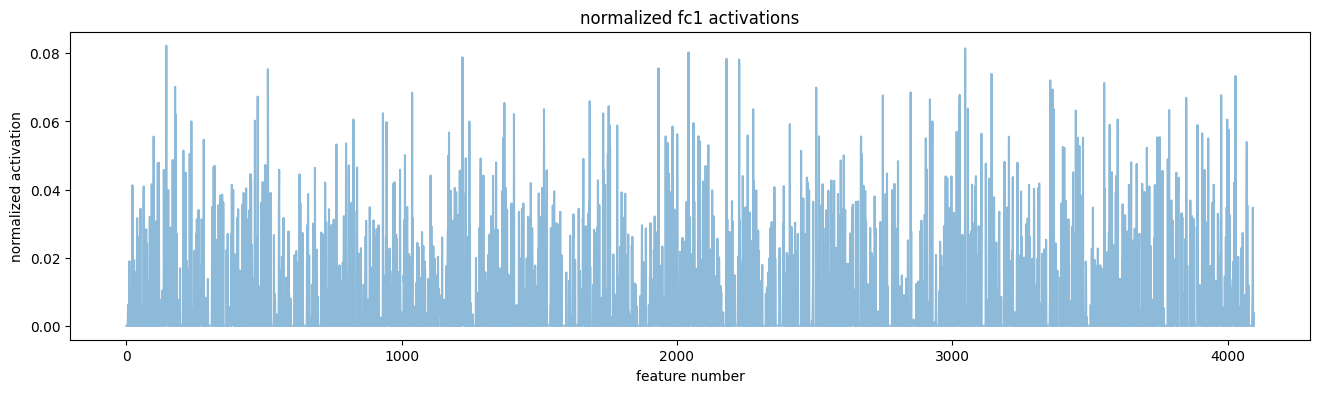

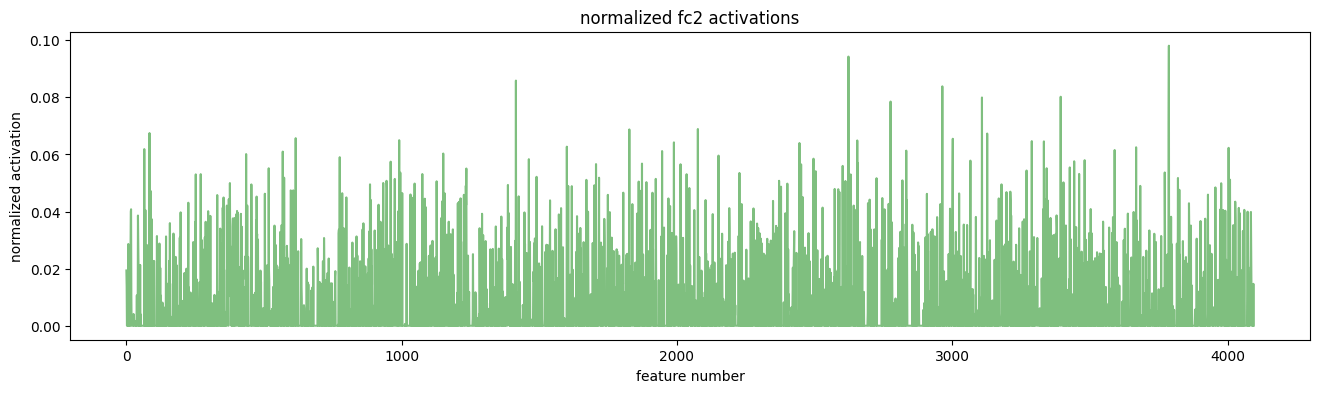

In [8]:
fc1_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer('fc1').output)
fc2_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer('fc2').output)
fc1_a = fc1_extractor.predict(x)
fc2_a = fc2_extractor.predict(x)
fc1_norm = preprocessing.normalize(fc1_a, norm='l2')
fc2_norm = preprocessing.normalize(fc2_a, norm='l2')
plt.figure(figsize=(16, 4))
plt.plot(fc1_norm[0], alpha=0.5)
plt.title('normalized fc1 activations')
plt.xlabel('feature number')
plt.ylabel('normalized activation')
plt.figure(figsize=(16, 4))
plt.plot(fc2_norm[0], color='green', alpha=0.5)
plt.title('normalized fc2 activations')
plt.xlabel('feature number')
plt.ylabel('normalized activation')
plt.show()

In [10]:
all_paths = [path for paths in list(art_by_style.values()) for path in paths]
file_mapping = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)
V_2 = fc2_extractor.predict(X)
V_1_norm = preprocessing.normalize(V_1, norm='l2')
V_2_norm = preprocessing.normalize(V_2, norm='l2')

60/60 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step


In [11]:
all_paths = [path for path in list(art_by_style['chair'])]
file_mapping_chairs = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_chair = preprocessing.normalize(V_1, norm='l2')


8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step


In [12]:
import os
import pickle

# Define the directory path
directory = 'file_mapping/chair/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Now save the files
pickle.dump(file_mapping_chairs, open(os.path.join(directory, 'file_mapping_chair.p'), 'wb'))
pickle.dump(V_1_norm_chair, open(os.path.join(directory, 'V_1_norm_chair.p'), 'wb'))


## Extract feature and normalize vectors for specific category of furnitures

In [12]:
# import os
# import pickle
# import numpy as np
# from sklearn import preprocessing

# # Ensure the directory exists
# directory = 'file_mapping/lamp/'
# if not os.path.exists(directory):
#     os.makedirs(directory)

# # Process images and extract features
# all_paths = [path for path in list(art_by_style['lamp'])]
# file_mapping_lamp = {i: path for i, path in enumerate(all_paths)}
# x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
# X = np.vstack(x_list)

# # Extract features and normalize vectors
# V_1 = fc1_extractor.predict(X)
# V_1_norm_lamp = preprocessing.normalize(V_1, norm='l2')

# # Save the data
# pickle.dump(file_mapping_lamp, open(os.path.join(directory, 'file_mapping_lamp.p'), 'wb'))
# pickle.dump(V_1_norm_lamp, open(os.path.join(directory, 'V_1_norm_lamp.p'), 'wb'))


In [13]:
import os
import pickle
import numpy as np
from sklearn import preprocessing

# Ensure the directory exists
directory = 'file_mapping/bed/'
if not os.path.exists(directory):
    os.makedirs(directory)

# Process images and extract features
all_paths = [path for path in list(art_by_style['bed'])]
file_mapping_beds = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)

# Extract features and normalize vectors
V_1 = fc1_extractor.predict(X)
V_1_norm_beds = preprocessing.normalize(V_1, norm='l2')

# Save the data
pickle.dump(file_mapping_beds, open(os.path.join(directory, 'file_mapping_bed.p'), 'wb'))
pickle.dump(V_1_norm_beds, open(os.path.join(directory, 'V_1_norm_bed.p'), 'wb'))


7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step


In [14]:
import os
import pickle
import numpy as np
from sklearn import preprocessing

# Ensure the directory exists
directory = 'file_mapping/couch/'
if not os.path.exists(directory):
    os.makedirs(directory)

# Process images and extract features
all_paths = [path for path in list(art_by_style['couch'])]
file_mapping_sofa = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)

# Extract features and normalize vectors
V_1 = fc1_extractor.predict(X)
V_1_norm_sofa = preprocessing.normalize(V_1, norm='l2')

# Save the data
pickle.dump(file_mapping_sofa, open(os.path.join(directory, 'file_mapping_couch.p'), 'wb'))
pickle.dump(V_1_norm_sofa, open(os.path.join(directory, 'V_1_norm_couch.p'), 'wb'))


37/37 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step


In [15]:
import os
import pickle
import numpy as np

from sklearn import preprocessing

# Ensure the directory exists
directory = 'file_mapping/dining table/'
if not os.path.exists(directory):
    os.makedirs(directory)

# Process images and extract features
all_paths = [path for path in list(art_by_style['dining table'])]
file_mapping_tables = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)

# Extract features and normalize vectors
V_1 = fc1_extractor.predict(X)
V_1_norm_tables = preprocessing.normalize(V_1, norm='l2')

# Save the data
pickle.dump(file_mapping_tables, open(os.path.join(directory, 'file_mapping_dining table.p'), 'wb'))
pickle.dump(V_1_norm_tables, open(os.path.join(directory, 'V_1_norm_dining table.p'), 'wb'))


10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step


In [ ]:
all_paths = [path for path in list(art_by_style['lamp'])]
file_mapping_lamp = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_lamp = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_lamp, open('file_mapping/lamp/file_mapping_lamp.p', 'wb'))
pickle.dump(V_1_norm_lamp, open('file_mapping/lamp/V_1_norm_lamp.p', 'wb'))


In [ ]:
all_paths = [path for path in list(art_by_style['couch'])]
file_mapping_sofa = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_sofa = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_sofa, open('file_mapping/sofa/file_mapping_couch.p', 'wb'))
pickle.dump(V_1_norm_sofa, open('file_mapping/sofa/V_1_norm_couch.p', 'wb'))


## Testing how feature extractors work with recommending furnitures

In [17]:
def similarity_search(V, v_query, file_mapping, n_results=6):
    v_query = np.expand_dims(v_query, axis=0)
    d = V.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(np.ascontiguousarray(V))
    distances, closest_indices = index.search(v_query, n_results)
    distances = distances.flatten()
    closest_indices = closest_indices.flatten()
    closest_paths = [file_mapping[idx] for idx in closest_indices]
    #query_img = get_concatenated_images([file_mapping[query_idx]])
    results_img = get_concatenated_images(closest_paths[1:])
    
    # plt.figure(figsize=(5, 5))
    # plt.imshow(compare)
    # plt.title('query image')

    plt.figure(figsize=(16, 12))
    plt.imshow(results_img)
    plt.title(f'results similarities: {distances}')
    plt.show()

def image_upload(img, target_size):
    img = ImageOps.fit(img, target_size, Image.ANTIALIAS)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


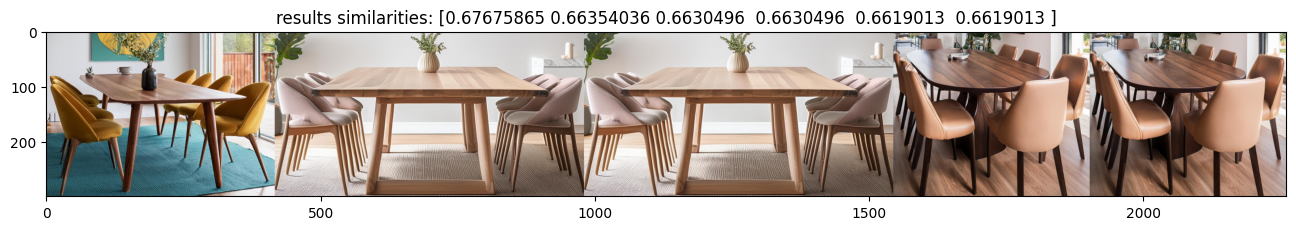

In [18]:
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn import preprocessing

def image_upload(img, target_size):
    img = ImageOps.fit(img, target_size, Image.Resampling.LANCZOS)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x, img

compare = preprocessing.normalize(
    fc1_extractor.predict(image_upload(Image.open('../cropped_items/item_dining table_3.jpg'), model.input_shape[1:3])[0]), norm="l2"
).reshape(4096,)

similarity_search(V_1_norm, compare, file_mapping)
